# DAGs: probabilistic expert systems and structural learning

This project is based solely on existing software and it is a guided tour through some of the many uses of DAGs in applied sciences

It assumes that the R library `gRain` has been installed. To install gRain you most likely need to install `gRbase` that in turns requires `Rgraphviz` and `RBGL` that can be installed from Bioconductor, see [here](https://www.bioconductor.org/packages/release/bioc/html/RBGL.html) and [here](https://www.bioconductor.org/packages/release/bioc/html/Rgraphviz.html)

We also use the R library `bnlearn`, for which useful information can be found in http://www.bnlearn.com/

In [ ]:
install.packages("BiocManager")
BiocManager::install("RBGL")
BiocManager::install("Rgraphviz")

install.packages('gRain')
install.packages('bnlearn')

In [64]:
library(gRain)
library(bnlearn)
library(gRbase)
library(graph)

## Building, estimating and querying a probabilistic expert system using DAGs

Heere we follow closely Chapter 3 of Hojsgaard, Edwards and Lauritzen "Graphical models with R" (or equivalently a Journal of Statistical Software publication on the use of gRain)


### The Chest Clinic example

This is a classic example/dataset first introduced in Lauritzen and Spiegelhalter (1988)*"Local computations with probabilities on graphical structures and their application to expert systems"*

The context: 
Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or
none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis.
The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.

The main variables are all *binary* (yes/no) and below are coded as
`
asia,tub,smoke,lung,bronc,either,xray,dysp
`

In this case the consultation with the public health experts has determined the structure of the DAG, we do not need to learn it from data 

The following commands define the DAG; ~ specifies a variable and | the parents separated by : if more than one

The model requires values for each categorical variable and conditional probabilities to be complete. These can be estimated from hospital records, and are available for this example. They are specified below as conditional probability tables using the `gRain` functions; notice that probs can be given as unnormalized positive numbers

In [65]:
# provide levels and conditional probabilities
yn <- c('yes', 'no')
a <- cptable(~asia, values=c(1,99), levels=yn)
t.a <- cptable(~tub|asia, values=c(5,95,1,99), levels=yn)
s <- cptable(~smoke, values=c(5,5), levels=yn)
l.s <- cptable(~lung|smoke, values=c(1,9,1,99), levels=yn)
b.s <- cptable(~bronc|smoke, values=c(6,4,3,7), levels=yn)
e.lt <- cptable(~either|lung:tub,values=c(1,0,1,0,1,0,0,1),
levels=yn)
x.e <- cptable(~xray|either, values=c(98,2,5,95), levels=yn)
d.be <- cptable(~dysp|bronc:either, values=c(9,1,7,3,8,2,1,9),levels=yn)

In [66]:
#compile info into a DAG
plist <- compileCPT(list(a, t.a, s, l.s, b.s, e.lt, x.e, d.be))
#The compileCPT() function does some checking of the specified CPT’s. (For ex-
#ample, it is checked that the graph defined by the CPT’s is acyclic)
grn1 <- grain(plist)
summary(grn1)

Independence network: Compiled: FALSE Propagated: FALSE 
 Nodes : chr [1:8] "asia" "tub" "smoke" "lung" "bronc" "either" "xray" "dysp"


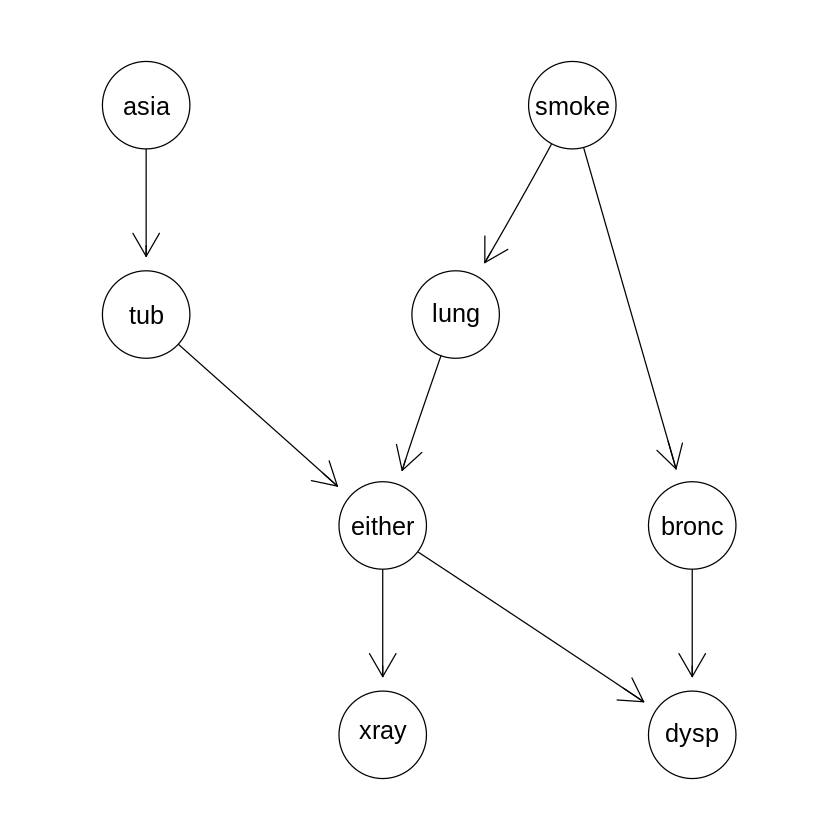

In [67]:
plot(grn1)

### Some background transformations for efficient probability computations

The following commands turn the DAG into an **undirected graphical model** - this transformation is crucial for doing computations efficiently with the corresponding density, the type of computations that we will be doing below. The final product of these tansformations is the so-called **junction tree** representation of the graph, the cornerstone of **belief propagation** for efficient computations

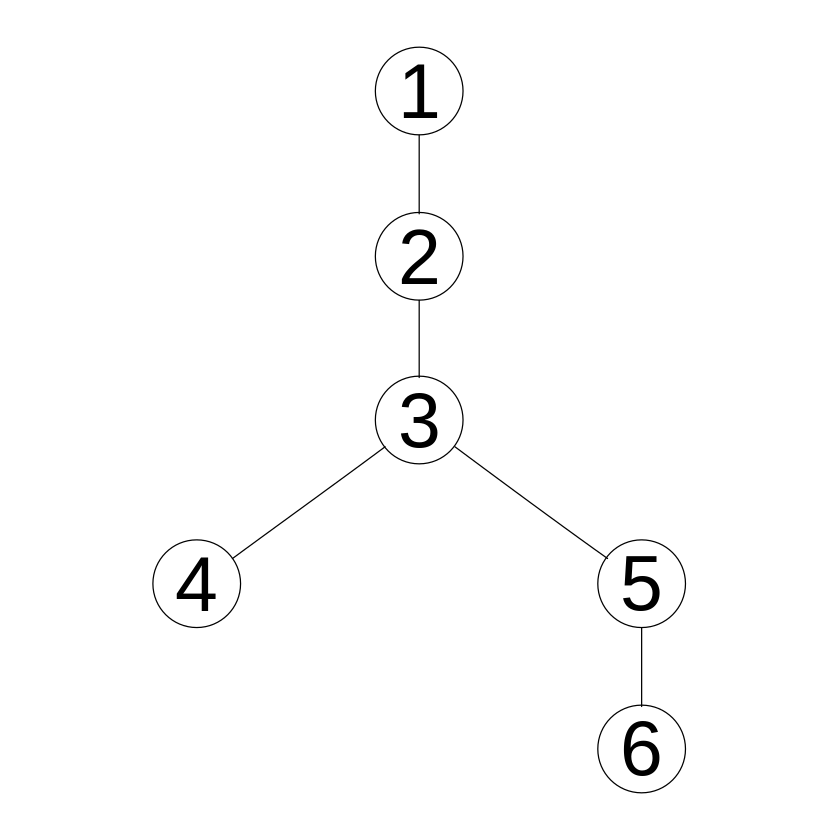

In [56]:
grn1c <- compile(grn1)
g <- grn1$dag
mg <- moralize(g)
tmg <- triangulate(mg)
grn1c <- propagate(grn1c)
plot(grn1c,type="jt")

In [57]:
# to understand what 1-6 stand for above:
rip(tmg)

cliques
  1 : asia tub 
  2 : either lung tub 
  3 : either lung bronc 
  4 : smoke lung bronc 
  5 : either dysp bronc 
  6 : either xray 
separators
  1 :  
  2 : tub 
  3 : either lung 
  4 : lung bronc 
  5 : either bronc 
  6 : either 
parents
  1 : 0 
  2 : 1 
  3 : 2 
  4 : 3 
  5 : 3 
  6 : 5 
[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL


### Feeding information and querying the system

Suppose that a patient walks into the clinic with dyspnoea, has recently travelled to Asia and is a smoker. We wish to compute the probability that she has lung cancer. Mathematically, we are interested in the marginal-conditional:

$$p(lung = "yes" | asia = "yes", dysp = "yes", smoke = "yes")$$

which involves conditioning on `asia,dysp,smoke` and marginalizing over the rest else except for `lung`. This type of computation can be very demanding (especially when the rest involves many variables with several levels) if done naively. However the representation of the joint density using the undirected graphical model allows an efficient computation of this. 

In `gRain` the conditioning on information is done using `setFinding()` which creates a new grain object

In [61]:
grn1c.ev <- setFinding(grn1c,nodes=c("asia","dysp","smoke"), states=c('no', 'yes', 'yes'))

Computation of such marginal probabilities (potentially conditioned on input info) are obtained efficiently using the `querygrain` function

In [62]:
querygrain(grn1c.ev,nodes=c("lung"), type="marginal")

$lung
lung
      yes        no 
0.1483626 0.8516374

In [60]:
# This is the probability of lung cancer without the additional info about asia and dyspnoea
# you can appreciate how the beliefs have changed with the additional info
querygrain(grn1c,nodes=c("lung"), type="marginal")

$lung
lung
  yes    no 
0.055 0.945

**Question 1**: compute

$$p(lung = "yes" | dysp = "yes", smoke = "yes")$$

What are your conclusions relative to the probability 

$$p(lung = "yes" | asia = "yes", dysp = "yes", smoke = "yes")$$

computed earlier? 

**Question 2**: A medical doctor claims that if the tuberculosis and dyspnoea status of a patient is known, the X-ray is not useful in order to determine whether the patient suffers from bronchitis. Formulate mathematically what this claim corresponds to, and use basic d-separation arguments to check its validity. 

`gRain` does not include functions to answer such d-separation questions. One can instead use other R libraries, e.g. `bnlearn`. We can easily create a `bnlearn` object from the `gRain` one. Investigate how the `bnlearn` functions: `as.bn`, `plot` and `dsep` can help you verify that your answer above is correct

## Structural learning

We will work with a simulated dataset based on the kidney stone example and do a little experimentation with structural learning using a constraint-based method. These methods do tests of (conditional) independence between variables to establish existence of undirected edges and using the established edges and the acyclic assumption direct certain edges. A priori knowledge can be incorporated into the structural learning by either asking that certain directed edges should be missing (e.g. from the effect of an operation to the treatment used in the operation) - this is known as *blacklisting* - or should be present - this is known as *whitelisting*. 

### Little project on structure learning

Using the conditional probabilities provided for the kidney stone example define a DAG and plot it. Then, using the `gRain` function `simulate` generate two datasets from this model, a smaller one of 700 people and and a larger one of 7000 people. Explore the `gs` function in `bnlearn` to learn the DAG from the generated data, for each of the datasets, which implements a constraint-based approach. Using the knowledge of this problem you can blacklist arrows going from success of operation to treatment and to size of stone, and arrows going from treatment to size of stone. What do you observed when you apply the method to the larger and smaller datasets? If there are differences in the structure learned, why are there?

